# Pipe grouing exploration

This notebook explores features for grouping wall decay coefficients in the Bristol Water Field Lab. This includes physical pipe properties
- material
- age
- diameter
  
and operational conditions
- mean and maximum velocities
- pipes with self-cleaning velocities
- mean residence time

Different combinations of these features are then used in the deterministic (Genetic algorithm) and probabalistic (Bayesian inference) calibration of wall decay coefficients.

In [133]:
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
from datetime import datetime
from bayesian_wq_calibration.data import load_network_data
from bayesian_wq_calibration.constants import NETWORK_DIR, INP_FILE, TIMESERIES_DIR
from bayesian_wq_calibration.epanet import build_model, epanet_simulator, sensor_model_id

### Load network data

Get EPANET and GIS data.

In [15]:
wdn = load_network_data(NETWORK_DIR / INP_FILE)
link_df = wdn.link_df
node_df = wdn.node_df
net_info = wdn.net_info
gis_df = pd.read_excel(NETWORK_DIR / 'gis_data.xlsx')

Run EPANET simulation to get hydraulic data.

In [131]:
data_period = 20 # load operational data for a given period (up to 21)
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
except:
    print(f"Data period {data_period} does not exist.")

# build wntr model
demand_resolution = 'wwmd'
wn = build_model(flow_df, pressure_df, cl_df, sim_type='hydraulic', demand_resolution=demand_resolution)

# run epanet simulator
sim = epanet_simulator(wn, 'velocity', cl_df)
vel = sim.velocity.T

In [136]:
# get velocity features
vel_mean = vel.mean(axis=1)
vel_max = vel.max(axis=1) 
scc_thresh = 0.2
vel_scc = (vel_max > scc_thresh).astype(int)

vel_df = pd.DataFrame({
    'model_id': vel_mean.index,
    'vel_mean': vel_mean.values,
    'vel_max': vel_max.values,
    'vel_scc': vel_scc.values
})

Merge physical and operational pipe properties to single dataframe.

In [212]:
feature_df = link_df.copy()

# merge dataframes
feature_df = feature_df.merge(
    gis_df[['model_id', 'material', 'age']], 
    left_on='link_ID', right_on='model_id', how='left'
).drop(columns=['model_id']).rename(columns={'link_ID': 'model_id'})
feature_df = feature_df[['model_id'] + [col for col in feature_df.columns if col != 'model_id']]
feature_df = feature_df.merge(vel_df, on='model_id', how='left')

# compute additional features
feature_df['vel_mean'] = feature_df['vel_mean'].replace(0, np.nan)
feature_df['mean_residence_time_h'] = feature_df['length'] / feature_df['vel_mean'] / 3600
feature_df['age'] = feature_df['age'].where(feature_df['age'] >= 1800, np.nan)
feature_df['age'] = datetime.now().year - feature_df['age']
max_age = int(feature_df['age'].max(skipna=True))
feature_df['age'] = feature_df['age'].fillna(max_age).astype(int)

feature_df

,model_id,link_type,diameter,length,n_exp,C,node_out,node_in,material,age,vel_mean,vel_max,vel_scc,mean_residence_time_h
0,link_0001,pipe,0.0508,5.48,1.852,53.2,node_0007,node_2241,CI,143,1.448254e-06,0.000008,0,1051.074224
1,link_0002,pipe,0.0127,3.1,1.852,53.2,node_0009,node_0832,CI,143,6.584007e-05,0.000179,0,13.078831
2,link_0003,pipe,0.178,2.15,1.852,53.2,node_0837,node_0010,CI,143,6.856705e-02,0.110302,0,0.00871
3,link_0004,pipe,0.0965,18.700001,1.852,140.47,node_0013,node_2264,AC,36,7.039508e-07,0.000002,0,7378.988569
4,link_0005,pipe,0.1485,57.93,1.852,140.47,node_0015,node_2262,AC,32,4.191127e-02,0.083414,0,0.383946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,link_2930,valve,0.08,0.16,2,0.0001,node_2141,node_2109,NaN,148,1.096470e-02,0.018389,0,0.004053
2930,link_2931,valve,0.1,0.2,2,0.0001,node_2147,node_2145,NaN,148,3.440633e-03,0.005850,0,0.016147
2931,link_2932,valve,0.08,0.16,2,0.0001,node_2151,node_2150,NaN,148,3.533871e-03,0.006009,0,0.012577
2932,link_2933,valve,0.1,0.2,2,0.0001,node_2155,node_2156,NaN,148,6.658531e-02,0.116189,0,0.000834


Define network plotting function.

In [266]:
def plot_features(feature_df, reservoir=False, wq_sensors=False, show_legend=False, feature=None):
    
    uG = nx.from_pandas_edgelist(feature_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}

    x_coords = [pos[node][0] for node in uG.nodes()]
    y_coords = [pos[node][1] for node in uG.nodes()]

    reservoir_nodes = net_info['reservoir_names']
    reservoir_x = [pos[node][0] for node in reservoir_nodes]
    reservoir_y = [pos[node][1] for node in reservoir_nodes]

    reservoir_trace = go.Scatter(
        x=reservoir_x,
        y=reservoir_y,
        mode='markers',
        marker=dict(
            size=15,
            color='blue',
            symbol='square'
        ),
        text=['inlet_2296', 'inlet_2005'],
        hoverinfo='text',
        name='DMA inlet'
    )

    if wq_sensors:
        sensor_data = sensor_model_id('wq')
        sensor_names = sensor_data['model_id'].values
        sensor_x = [pos[node][0] for node in sensor_names]
        sensor_y = [pos[node][1] for node in sensor_names]
        sensor_hydrant = [2, 5, 6]
        sensor_kiosk = [i for i in list(range(len(sensor_names))) if i not in sensor_hydrant]
        
        wq_trace_kiosk = go.Scatter(
            x=[sensor_x[i] for i in sensor_kiosk],
            y=[sensor_y[i] for i in sensor_kiosk],
            mode='markers',
            marker=dict(
                size=14,
                color='black',
                line=dict(color='white', width=2),
                symbol='square'
            ),
            text=[str(sensor_data['bwfl_id'][idx]) for idx in sensor_kiosk],
            hoverinfo='text',
            name='water quality sensor (kiosk)'
        )

        wq_trace_hydrant = go.Scatter(
            x=[sensor_x[i] for i in sensor_hydrant],
            y=[sensor_y[i] for i in sensor_hydrant],
            mode='markers',
            marker=dict(
                size=14,
                color='black',
                line=dict(color='white', width=2)
            ),
            text=[str(sensor_data['bwfl_id'][idx]) for idx in sensor_hydrant],
            hoverinfo='text',
            name='water quality sensor (hydrant)'
        )

    fig = go.Figure()

    if feature is not None:
        if feature in feature_df.columns:
            unique_values = feature_df[feature].unique()

            color_map = {value: color for value, color in zip(unique_values, plotly.colors.qualitative.Dark24)}

            for group, color in color_map.items():
                group_df = feature_df[feature_df[feature] == group]
                uG_group = nx.from_pandas_edgelist(group_df, source='node_out', target='node_in')

                edge_x = []
                edge_y = []
                hover_text = []
                for edge in uG_group.edges():
                    x0, y0 = pos[edge[0]]
                    x1, y1 = pos[edge[1]]
                    edge_x.extend([x0, x1, None])
                    edge_y.extend([y0, y1, None])

                edge_trace = go.Scatter(
                    x=edge_x,
                    y=edge_y,
                    line=dict(width=1.0, color=color),
                    hoverinfo='text',
                    text=f"{feature}: {group}",
                    mode='lines',
                    name=f'{group}'
                )
                fig.add_trace(edge_trace)

    else:
        edge_x = []
        edge_y = []
        for edge in uG.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
    
        edge_trace = go.Scatter(
            x=edge_x,
            y=edge_y,
            line=dict(width=1.0, color='black'),
            hoverinfo='none',
            mode='lines',
            name='link',
        )
        fig.add_trace(edge_trace)
    
    if reservoir:
        fig.add_trace(reservoir_trace)

    if wq_sensors:
        fig.add_trace(wq_trace_kiosk)
        fig.add_trace(wq_trace_hydrant)

    fig.update_layout(
        showlegend=show_legend,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=650,
        height=600,
        paper_bgcolor='white',
        plot_bgcolor='white',
        # legend=dict(title=dict(text="Legend", font=dict(size=14)))
    )

    fig.show()

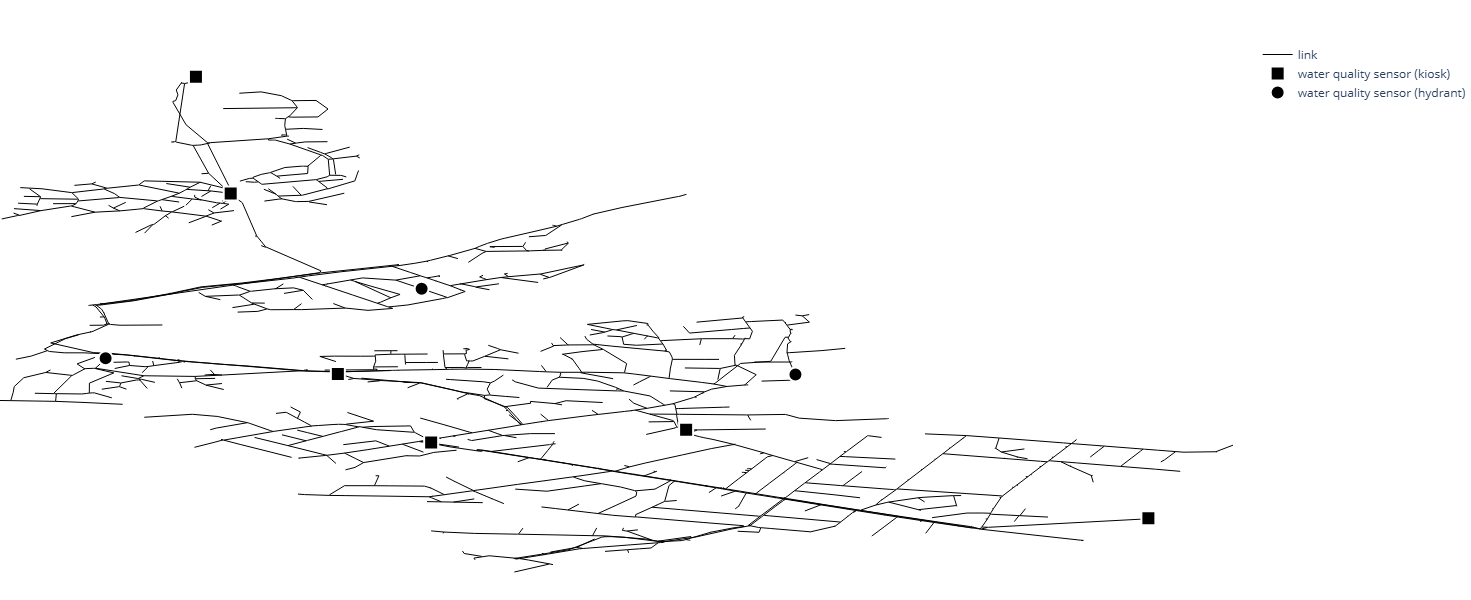

In [267]:
plot_features(feature_df, wq_sensors=True, show_legend=True)

### Physical pipe properties

#### Material

Add material group feature.

In [268]:
# material group
M1 = ['CI', 'SI', 'Pb', 'DI', 'ST']
M2 = ['AC']
M3 = ['HPPE', 'HPPE+FOIL', 'LDPE', 'MDPE', 'MDPE+FOIL', 'PE100+Skin', 'PVC', 'Unknown']

feature_df['material_group'] = [
    'M1' if material in g1_material else 
    'M2' if material in g2_material else 
    'M3' if material in g3_material else 
    np.nan
    for material in feature_df['material']
]

Plotting code.

In [269]:
feature = 'material' # 'material', 'material_group'

# network plot
plot_features(feature_df, wq_sensors=True, show_legend=True, feature=feature)

# histogram
fig = go.Figure(data=[go.Histogram(x=feature_df[feature], marker=dict(color=default_colors[0]))])
fig.update_layout(
    title=f"histogram by feature: {feature}",
    xaxis_title=feature,
    yaxis_title=f"frequency (n={len(material)})",
    template="simple_white",
    width=750,
    height=450
)
fig.show()